# ARIMA Models

In [1]:
import sys
from utils import *

In [2]:
import warnings
warnings.simplefilter('ignore')

## Stationarity and differencing

A stationary time series is one whose properties do not depend on the time at which the series is observed.

In [3]:
goog = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\gafa_stock.csv')
        .query("Symbol == 'GOOG'"))
goog

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
3774,GOOG,2014-01-02,554.125916,555.263550,550.549194,552.963501,552.963501,3666400
3775,GOOG,2014-01-03,553.897461,554.856201,548.894958,548.929749,548.929749,3355000
3776,GOOG,2014-01-06,552.908875,555.814941,549.645081,555.049927,555.049927,3561600
3777,GOOG,2014-01-07,558.865112,566.162659,556.957520,565.750366,565.750366,5138400
3778,GOOG,2014-01-08,569.297241,569.953003,562.983337,566.927673,566.927673,4514100
...,...,...,...,...,...,...,...,...
5027,GOOG,2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
5028,GOOG,2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300
5029,GOOG,2018-12-27,1017.150024,1043.890015,997.000000,1043.880005,1043.880005,2109800
5030,GOOG,2018-12-28,1049.619995,1055.560059,1033.099976,1037.079956,1037.079956,1414800


In [4]:
goog.set_index(pd.to_datetime(goog.Date, format='%Y-%m-%d'))

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,,,
2014-01-02,GOOG,2014-01-02,554.125916,555.263550,550.549194,552.963501,552.963501,3666400
2014-01-03,GOOG,2014-01-03,553.897461,554.856201,548.894958,548.929749,548.929749,3355000
2014-01-06,GOOG,2014-01-06,552.908875,555.814941,549.645081,555.049927,555.049927,3561600
2014-01-07,GOOG,2014-01-07,558.865112,566.162659,556.957520,565.750366,565.750366,5138400
2014-01-08,GOOG,2014-01-08,569.297241,569.953003,562.983337,566.927673,566.927673,4514100
...,...,...,...,...,...,...,...,...
2018-12-24,GOOG,2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
2018-12-26,GOOG,2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300
2018-12-27,GOOG,2018-12-27,1017.150024,1043.890015,997.000000,1043.880005,1043.880005,2109800


In [5]:
strikes = pd.read_excel(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\annual-listing.xlsx', skiprows=2)
strikes = strikes.loc[:71, strikes.columns[:2]].astype(int)
strikes.columns = 'Year', 'Count'
strikes

,Year,Count
0,1947,270
1,1948,245
2,1949,262
3,1950,424
4,1951,415
...,...,...
67,2014,11
68,2015,12
69,2016,15
70,2017,7


In [6]:
housing = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\enigma-us.gov_.census.eits_.ressales-e7513e56d76050c05caf638306055c98_1.csv')
 .query("dt_code == 'TOTAL' and cat_code == 'SOLD' and geo_desc == 'United States'")
 .rename(columns={'per_name':'date', 'val':'Count'})
 .pipe(compute, lambda x: dict(date = pd.to_datetime(x.date)))
 .set_index('date')
 [['Count']])

In [7]:
us_econ = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\global_economy.csv')
us_econ = (us_econ
           .query("Code == 'USA'")
           .assign(date=pd.to_datetime(us_econ.Year, format='%Y'))
           .set_index('date'))

In [8]:
#eggs = pd.read_csv('data/external/eggs.csv')
#eggs.columns = 'date', 'EggPrice'
#eggs = (
    #eggs
    #.set_index(pd.to_datetime(eggs.date))
    #.join(us_econ.resample('1MS').max().fillna(method='ffill')))

In [9]:
d = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\aus_livestock.csv')
vic_pigs = (d
 .assign(date=pd.to_datetime(d.Month, format='%Y %b'))
 .query("Animal == 'Pigs' and State == 'Victoria'")
 .groupby('date Animal'.split())
 .Count.sum()
 .reset_index()
 .set_index('date'))

In [10]:
lynx = rdatasets.data('datasets', 'lynx')
lynx = (lynx
 .assign(date=pd.to_datetime(lynx.time, format='%Y'))
 .set_index('date'))

In [11]:
d = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\aus_production.csv')
aus_production = (d
 .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
 .set_index('Date'))
recent_production = aus_production.query("Date.dt.year >= 1992")

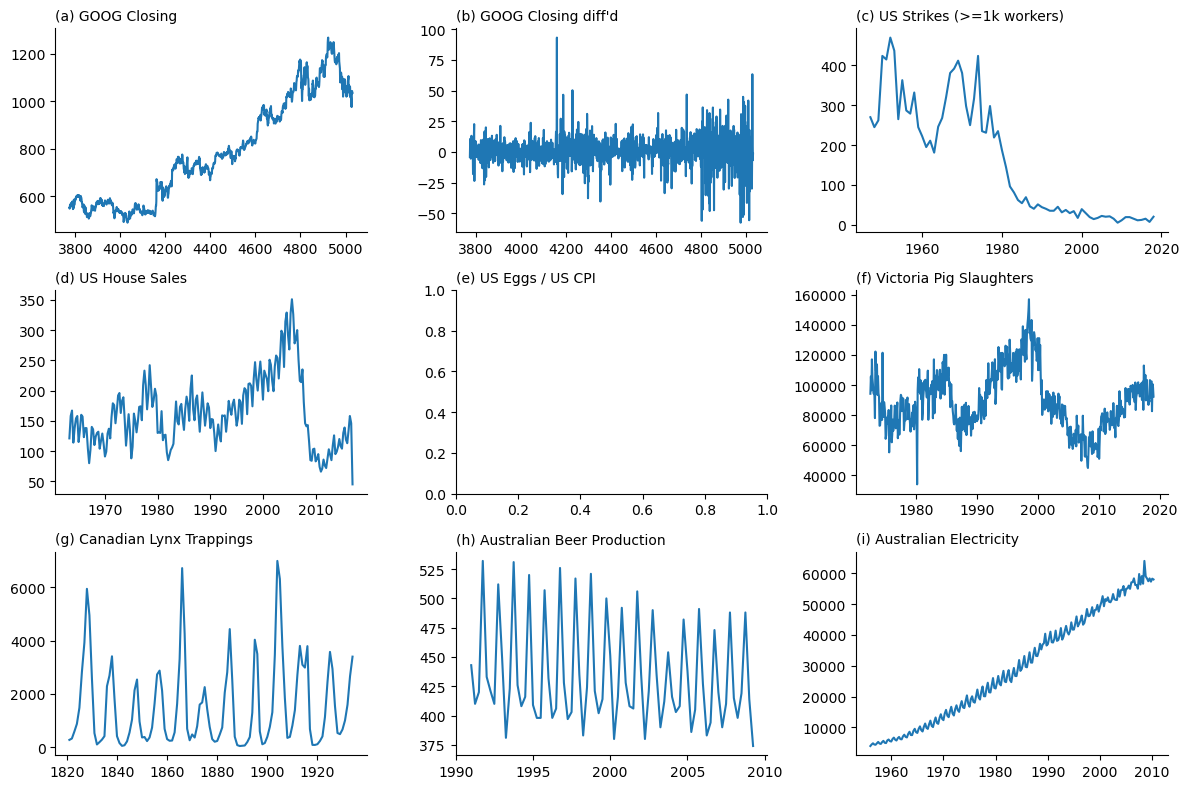

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.ravel()

d = goog
axs[0].plot(d.Close)
axs[1].plot(d.Close.diff())

d = strikes
axs[2].plot(d.Year, d.Count)

d = housing
axs[3].plot(d.resample('1q').sum().Count)

#d = eggs
#axs[4].plot((d.EggPrice / d.CPI).loc[:'1990'])

d = vic_pigs
axs[5].plot(d.Count)

d = lynx
axs[6].plot(d.value)

d = recent_production
axs[7].plot(d.Beer)

d = aus_production
axs[8].plot(d.Electricity)

titles = [
    'GOOG Closing',
    'GOOG Closing diff\'d',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity',
]
for (ax, title, letter) in zip(axs, titles, 'abcdefghi'):
    ax.set(title=f'({letter}) {title}')
xdate(axs[-2], '%Y', '5y')
plt.tight_layout()

### Differencing

In [13]:
goog

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
3774,GOOG,2014-01-02,554.125916,555.263550,550.549194,552.963501,552.963501,3666400
3775,GOOG,2014-01-03,553.897461,554.856201,548.894958,548.929749,548.929749,3355000
3776,GOOG,2014-01-06,552.908875,555.814941,549.645081,555.049927,555.049927,3561600
3777,GOOG,2014-01-07,558.865112,566.162659,556.957520,565.750366,565.750366,5138400
3778,GOOG,2014-01-08,569.297241,569.953003,562.983337,566.927673,566.927673,4514100
...,...,...,...,...,...,...,...,...
5027,GOOG,2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
5028,GOOG,2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300
5029,GOOG,2018-12-27,1017.150024,1043.890015,997.000000,1043.880005,1043.880005,2109800
5030,GOOG,2018-12-28,1049.619995,1055.560059,1033.099976,1037.079956,1037.079956,1414800


In [14]:
goog = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\gafa_stock.csv')
.query("Symbol == 'GOOG'")
.sort_values('Date')
.reset_index(drop=True)
.pipe(compute, lambda x: dict(Date = pd.to_datetime(x.Date, format='%Y-%m-%d'))))

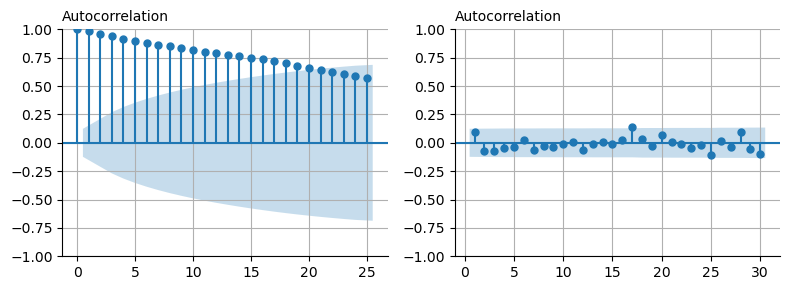

In [15]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(8,3))
d = g15 = goog.query('Date.dt.year == 2015')
sm.graphics.tsa.plot_acf(d.Close, ax=a1)
sm.graphics.tsa.plot_acf(d.Close.diff().dropna(), lags=np.r_[1:31], ax=a2)
[ax.grid() for ax in (a1, a2)]
plt.tight_layout()               

In [16]:
sm.stats.acorr_ljungbox(
    d.Close.diff().dropna(), lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.914143,0.637223,7.744517,0.653776


### Seasonal differencing

In [17]:
PBS = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\PBS.csv', parse_dates=['Month'])
a10 = (PBS
 .query('ATC2 == "A10"')
 .groupby('Month', sort=False)
 .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
 .reset_index()
 .set_index('Month', drop=False))
a10

,Month,Cost
Month,,
1991-07-01,1991-07-01,3.526591
1991-08-01,1991-08-01,3.180891
1991-09-01,1991-09-01,3.252221
1991-10-01,1991-10-01,3.611003
1991-11-01,1991-11-01,3.565869
...,...,...
2008-02-01,2008-02-01,21.654285
2008-03-01,2008-03-01,18.264945
2008-04-01,2008-04-01,23.107677


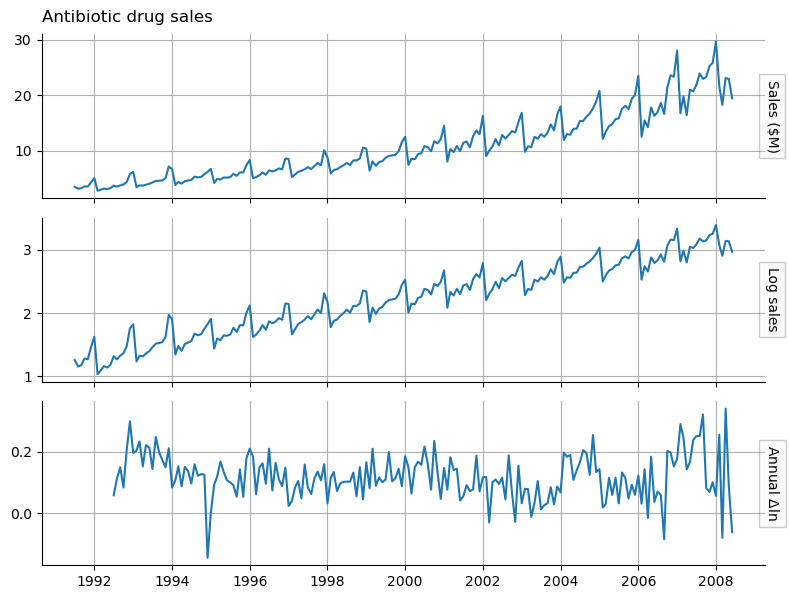

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(8,6), sharex=True)
d = a10
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
axs[2].plot(np.log(d.Cost).diff(12))
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Antibiotic drug sales')
fig.subplots_adjust(top=.95)

In [19]:
h02 = (PBS
 .query('ATC2 == "H02"')
 .groupby('Month', sort=False)
 .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
 .reset_index()
 .set_index('Month', drop=False))
h02

,Month,Cost
Month,,
1991-07-01,1991-07-01,0.429795
1991-08-01,1991-08-01,0.400906
1991-09-01,1991-09-01,0.432159
1991-10-01,1991-10-01,0.492543
1991-11-01,1991-11-01,0.502369
...,...,...
2008-02-01,2008-02-01,0.761822
2008-03-01,2008-03-01,0.649435
2008-04-01,2008-04-01,0.827887


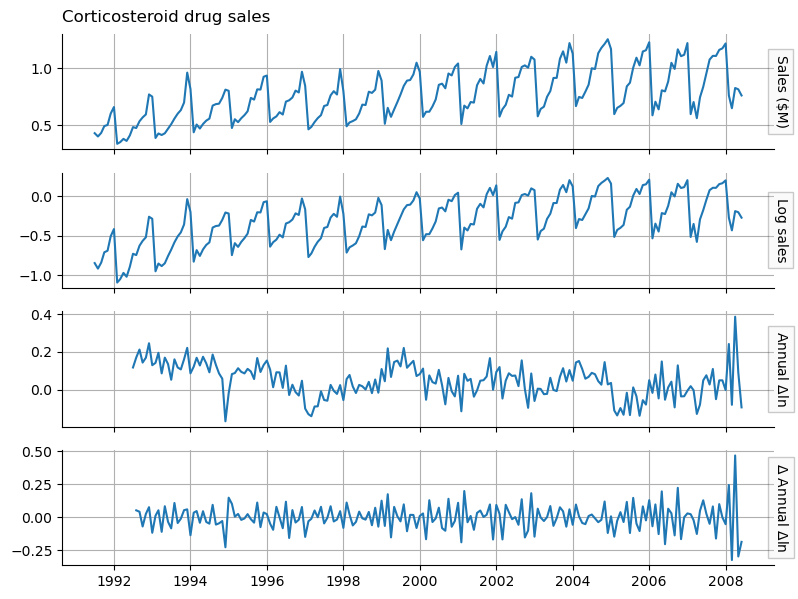

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
d = h02
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
axs[2].plot(np.log(d.Cost).diff(12))
axs[3].plot(np.log(d.Cost).diff(12).diff())
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$', '$\Delta$ Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Corticosteroid drug sales')
fig.subplots_adjust(top=.95)

### Unit root tests

In [21]:
sm.tsa.stattools.kpss(g15.Close, nlags='auto')

(2.009369275593288,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [22]:
sm.tsa.stattools.kpss(g15.Close.diff().diff().dropna(), nlags='auto')

(0.3093118156264576,
 0.1,
 104,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [23]:
ndiffs, nsdiffs = pmd.arima.ndiffs, pmd.arima.nsdiffs

In [24]:
ndiffs(g15.Close), nsdiffs(g15.Close, 30)

(1, 0)

In [25]:
ndiffs(a10.Cost), ndiffs(h02.Cost), nsdiffs(a10.Cost, 12), nsdiffs(h02.Cost, 12)

(1, 1, 1, 1)

## Moving average models

### US consumption expenditure

In [26]:
us_change = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\fpp3\us_change.csv')
us_change = (us_change
 .assign(date=pd.to_datetime(us_change.Quarter.str.replace(' ', '')))
 .set_index('date')
 .pipe(set_freq))

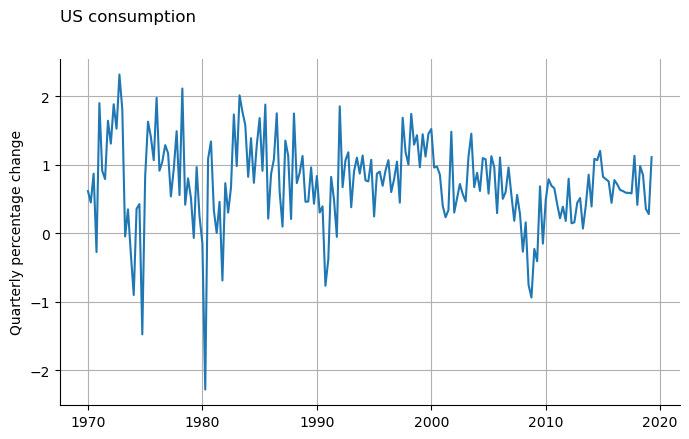

In [27]:
fig, ax = plt.subplots()
ax.plot(us_change.Consumption)
ax.set(ylabel='Quarterly percentage change')
suptitle('US consumption')
ax.grid()

In [28]:
fit = sm.tsa.SARIMAX(us_change.Consumption, order=(1, 0, 3), trend='c').fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -169.883
Date:                Fri, 21 Mar 2025   AIC                            351.766
Time:                        08:24:08   BIC                            371.495
Sample:                    01-01-1970   HQIC                           359.752
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3159      0.090      3.513      0.000       0.140       0.492
ar.L1          0.5732      0.124      4.639      0.000       0.331       0.815
ma.L1         -0.3619      0.128     -2.824      0.005      -0.613      -0.111
ma.L2          0.0925      0.061      1.528      0.127      -0.026       0.211
ma.L3          0.1933      0.076      2.547      0.011       0.045       0.342
sigma2         0.3250      0.023     14.190      0.000       0.280       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                74.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

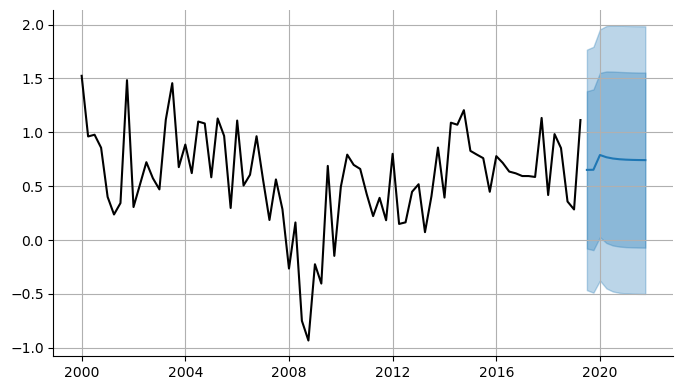

In [29]:
fig, ax = plt.subplots()
ax.plot(us_change['2000':].Consumption, 'k')

fc = fit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

### Understanding ARIMA

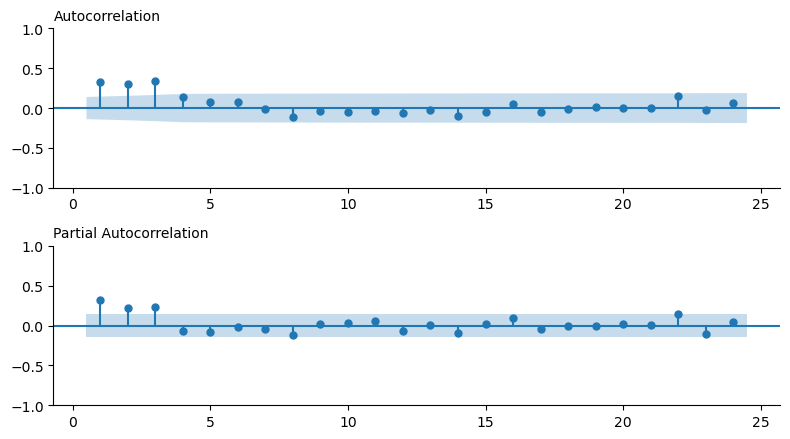

In [30]:
fig, axs = plt.subplots(2)
lags = np.r_[1:25]
sm.graphics.tsa.plot_acf(us_change.Consumption, lags=lags, ax=axs[0])
sm.graphics.tsa.plot_pacf(us_change.Consumption, lags=lags, ax=axs[1])
plt.tight_layout()

In [31]:
fit = sm.tsa.SARIMAX(us_change.Consumption, order=(3, 0, 0), trend='c').fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -170.300
Date:                Fri, 21 Mar 2025   AIC                            350.600
Time:                        08:24:09   BIC                            367.041
Sample:                    01-01-1970   HQIC                           357.255
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3045      0.060      5.090      0.000       0.187       0.422
ar.L1          0.2027      0.056      3.648      0.000       0.094       0.312
ar.L2          0.1605      0.055      2.907      0.004       0.052       0.269
ar.L3          0.2252      0.064      3.529      0.000       0.100       0.350
sigma2         0.3264      0.022     14.593      0.000       0.283       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                74.38
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Seasonal ARIMA

### ACF/PACF

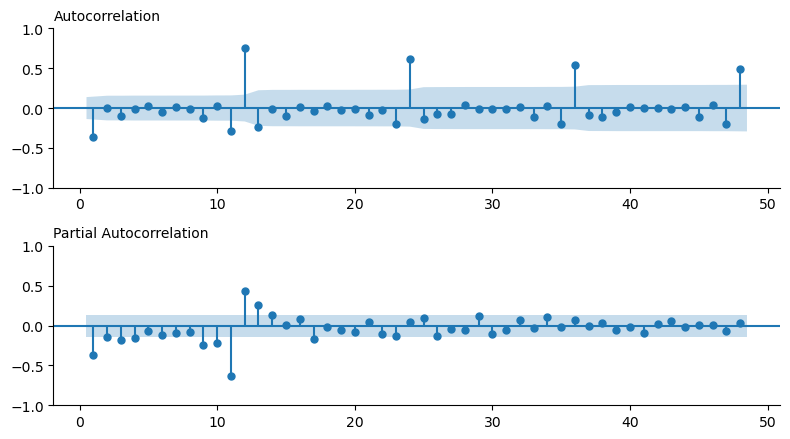

In [32]:
fig, axs = plt.subplots(2)
lags = np.r_[1:4*12+1]
sm.graphics.tsa.plot_acf(a10.Cost.diff().dropna(), lags=lags, ax=axs[0])
sm.graphics.tsa.plot_pacf(a10.Cost.diff().dropna(), lags=lags, ax=axs[1])
plt.tight_layout()

### Drug sales in Australia

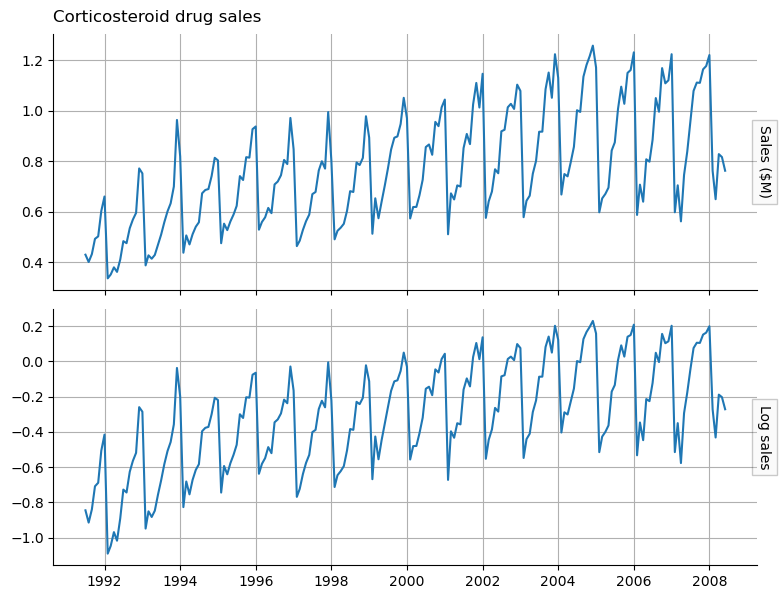

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
d = h02
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$', '$\Delta$ Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Corticosteroid drug sales')
fig.subplots_adjust(top=.95)

Check seasonal difference

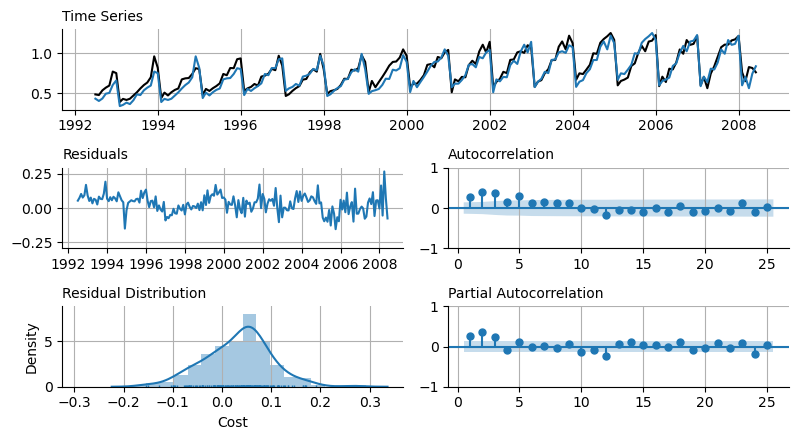

In [34]:
plot_tsresiduals(h02.Cost, h02.Cost.shift(12));

Brute force

In [35]:
%%time

results = []
P, D, d, m = 3, 0, 1, 12
for (Q, p, q) in tqdm(list(itertools.product(range(2), range(3), range(3)))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fit = sm.tsa.SARIMAX(np.log(h02.Cost), order=(P,D,Q), seasonal_order=(p,d,q,m)).fit()
        result = dict(P=P, Q=Q, D=D, p=p, d=d, q=q, m=m,
                      label=f'SARIMA({P},{D},{Q})({p}{d}{q}){m}',
                      AIC=fit.aic, fit=fit)
    results.append(result)
results = pd.DataFrame(results)

100%|██████████| 18/18 [00:35<00:00,  1.94s/it]

CPU times: total: 1min 11s
Wall time: 35 s


In [36]:
results.sort_values('AIC')['label AIC'.split()]

,label,AIC
16,"SARIMA(3,0,1)(211)12",-486.417203
11,"SARIMA(3,0,1)(012)12",-486.081504
17,"SARIMA(3,0,1)(212)12",-485.019891
2,"SARIMA(3,0,0)(012)12",-484.987935
13,"SARIMA(3,0,1)(111)12",-484.860258
7,"SARIMA(3,0,0)(211)12",-484.507807
14,"SARIMA(3,0,1)(112)12",-484.496563
4,"SARIMA(3,0,0)(111)12",-484.299352
1,"SARIMA(3,0,0)(011)12",-484.189630
10,"SARIMA(3,0,1)(011)12",-484.121839


In [37]:
results[11:12]

,P,Q,D,p,d,q,m,label,AIC,fit
11,3,1,0,0,1,2,12,"SARIMA(3,0,1)(012)12",-486.081504,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


Try with pmdarima

In [38]:
fit_auto = pmd.auto_arima(
    np.log(h02.Cost),
    seasonal=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.444, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-61.490, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.943, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.407, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.831 seconds


In [39]:
fit_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  32.203
Date:                Fri, 21 Mar 2025   AIC                            -62.407
Time:                        08:24:46   BIC                            -59.093
Sample:                    07-01-1991   HQIC                           -61.066
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0426      0.002     17.921      0.000       0.038       0.047
===================================================================================
Ljung-Box (L1) (Q):                   3.08   Jarque-Bera (JB):               325.68
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -2.16
Prob(H) (two-sided):                  0.75   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

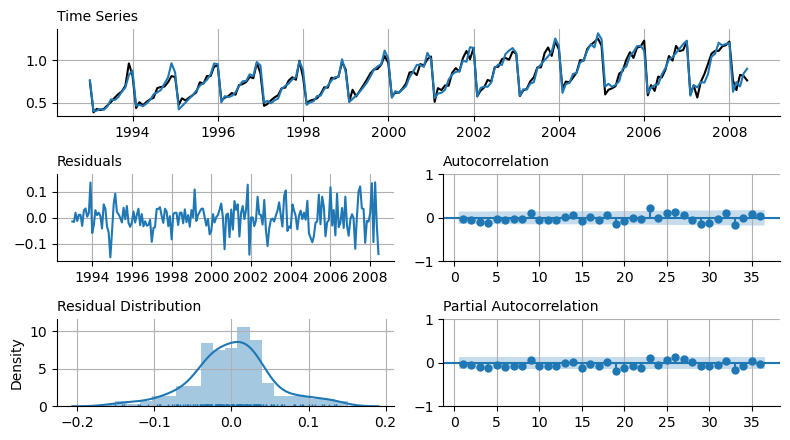

In [40]:
plot_tsresiduals(h02.Cost['1993':], 
                 np.exp(results.fit[11].fittedvalues['1993':]), 
                 acf_lags=np.r_[1:37]);

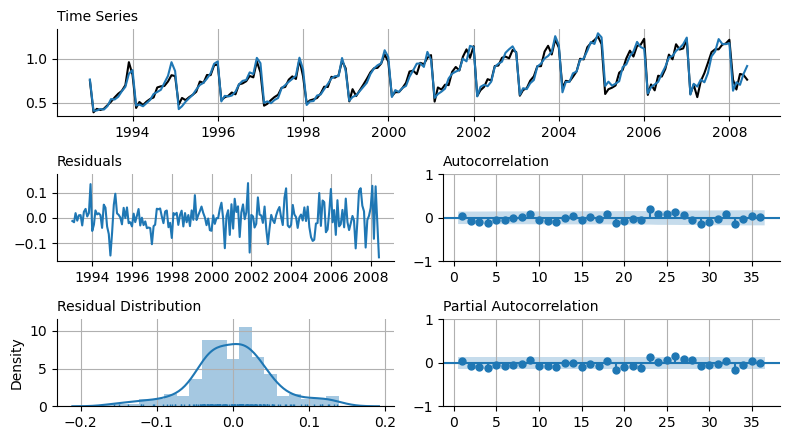

In [41]:
fit_auto.arima_res_
mask = h02.index >= '1993'
ypred = pd.Series(fit.fittedvalues[mask], index=h02.index[mask])
plot_tsresiduals(h02.Cost['1993':], np.exp(ypred), acf_lags=np.r_[1:37]);

### Test set evaluation

In [42]:
split = '2006-06-02'
tend = '2008-06-02'
dtrain, dtest = a10[:split], a10[split:tend]
fit = sm.tsa.SARIMAX(np.log1p(dtrain.Cost), order=(3, 0, 1), seasonal_order=(0, 1, 2, 12)).fit()
fit

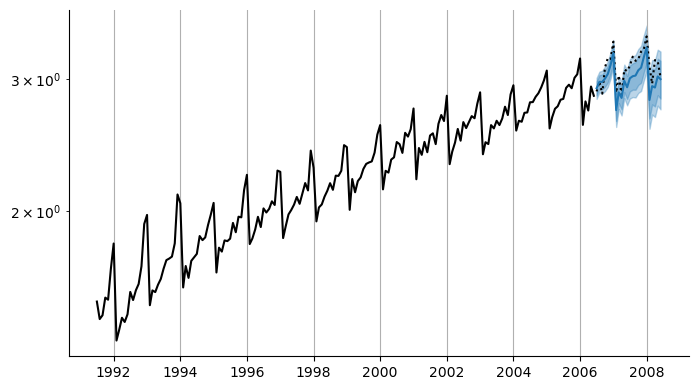

In [43]:
fig, ax = plt.subplots()
ax.plot(np.log1p(dtrain.Cost), 'k')
ax.plot(np.log1p(dtest.Cost), 'k:')
ax.semilogy()

fc = fit.get_forecast(2*12)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

In [44]:
fit = sm.tsa.SARIMAX(np.log1p(h02.Cost), order=(3, 0, 1), seasonal_order=(0,1,2,12)).fit()
fit

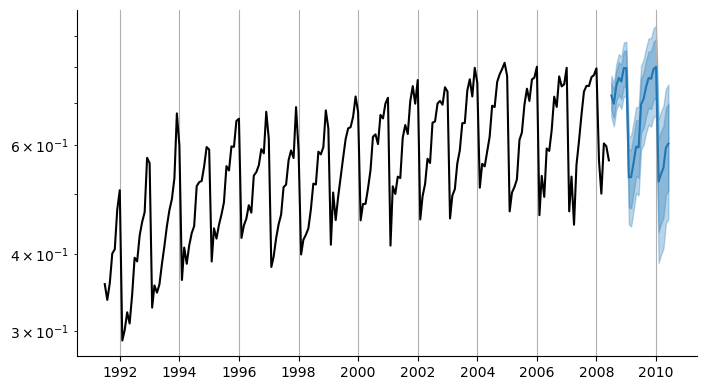

In [45]:
fig, ax = plt.subplots()
ax.plot(np.log1p(h02.Cost), 'k')
ax.semilogy()

fc = fit.get_forecast(2*12)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

### ARIMA vs ETS

In [46]:
glo_econ = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\global_economy.csv')
aus_econ = (glo_econ
 .assign(date=pd.to_datetime(glo_econ.Year, format='%Y'), Population=glo_econ.Population/1e6)
 .query("Code == 'AUS'")
 .set_index('date')
 .pipe(set_freq))
aus_econ['idx'] = np.arange(len(aus_econ))

In [47]:
pop_train_cv = pd.concat([aus_econ.iloc[:n]['idx Population'.split()]
           .assign(id=n) for n in range(10, len(aus_econ) - 10)])

In [48]:
pop_train_cv.id.nunique()

38

In [49]:
%%time
## ETS
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Y, y = np.transpose([(aus_econ.Population.iloc[d.idx.max()+1],
    sm.tsa.statespace.ExponentialSmoothing(set_freq(d).Population, trend=True).fit().forecast(1).values[0])
    for (i, d) in tqdm(pop_train_cv.groupby('id'))])
ets_metrics = RMSE(Y, y), MAE(Y, y), MAPE(Y, y)
ets_metrics

100%|██████████| 38/38 [00:03<00:00, 10.01it/s]

CPU times: total: 3.69 s
Wall time: 3.8 s


(0.10577876473441435, 0.07705967599806583, 0.5117407919795908)

In [50]:
%%time
## ARIMA
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Y, y = np.transpose([(aus_econ.Population.iloc[d.idx.max()+1],
    sm.tsa.SARIMAX(set_freq(d).Population, order=(3, 1, 1), trend='ct').fit().forecast(1).values[0])
    for (i, d) in tqdm(pop_train_cv.groupby('id'))])
arima_metrics = RMSE(Y, y), MAE(Y, y), MAPE(Y, y)
arima_metrics

100%|██████████| 38/38 [00:06<00:00,  5.68it/s]

CPU times: total: 6.44 s
Wall time: 6.7 s


(0.07664426491375723, 0.05199182206658868, 0.34434987306818066)

In [51]:
efit = sm.tsa.statespace.ExponentialSmoothing(aus_econ.Population, trend=True).fit()

In [52]:
afit = sm.tsa.SARIMAX(aus_econ.Population, order=(3, 1, 1), trend='ct').fit()

In [53]:
efit.aic, afit.aic

(-147.89550034964944, -148.1338511350122)

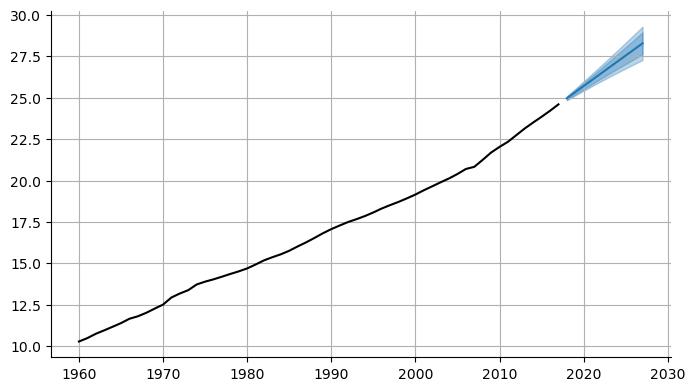

In [54]:
fig, ax = plt.subplots()
ax.plot(aus_econ.Population, 'k')

fc = efit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

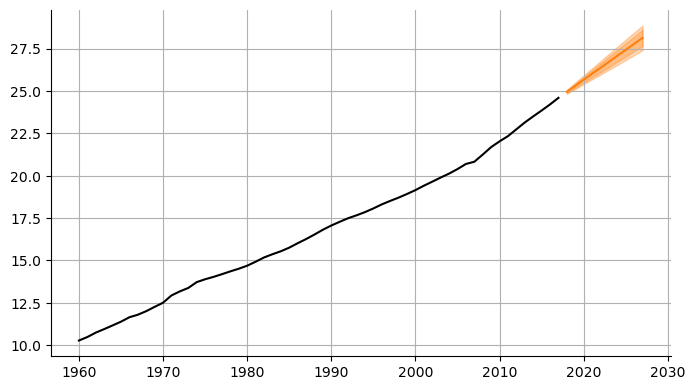

In [55]:
fig, ax = plt.subplots()
ax.plot(aus_econ.Population, 'k')

fc = afit.get_forecast(10)
ax.plot(fc.predicted_mean, color='C1')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)

ax.grid()

### ARIMA vs ETS on seasonal data

In [56]:
cement = set_freq(aus_production['1988':])

In [57]:
split = '2007'
dtrain, dtest = cement[:split], cement[split:]

In [58]:
efit = sm.tsa.statespace.ExponentialSmoothing(dtrain.Cement, trend=True, seasonal=4).fit()

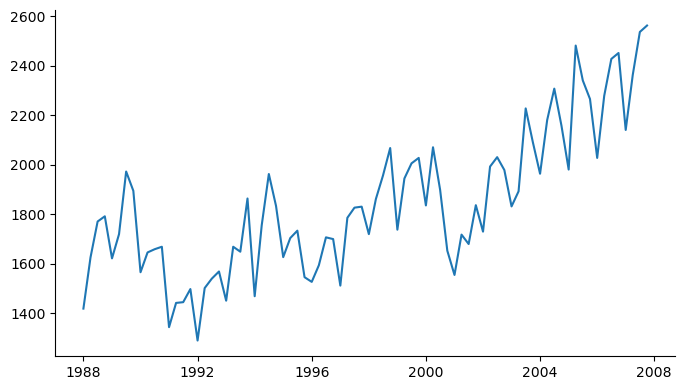

In [59]:
plt.plot(dtrain.Cement);

In [60]:
afit =  sm.tsa.SARIMAX(
    dtrain.Cement, order=(1,0,1), seasonal_order=(2,1,1,4), trend='ct').fit()

In [61]:
efit.aic, afit.aic

(987.2691820260927, 934.7676817216997)

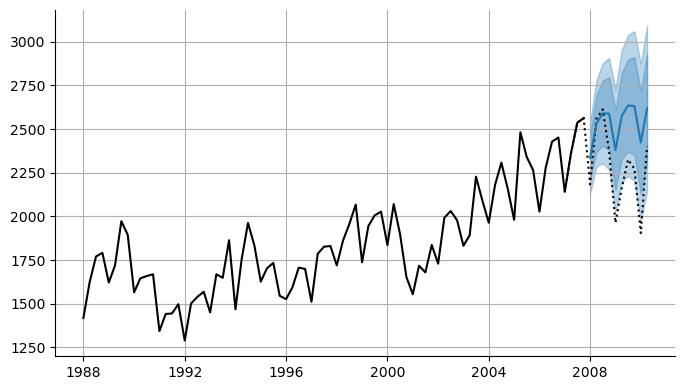

In [62]:
fig, ax = plt.subplots()
ax.plot(dtrain.Cement, 'k')
ax.plot(dtest.Cement, 'k:')

fc = efit.get_forecast(10)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3)

ax.grid()

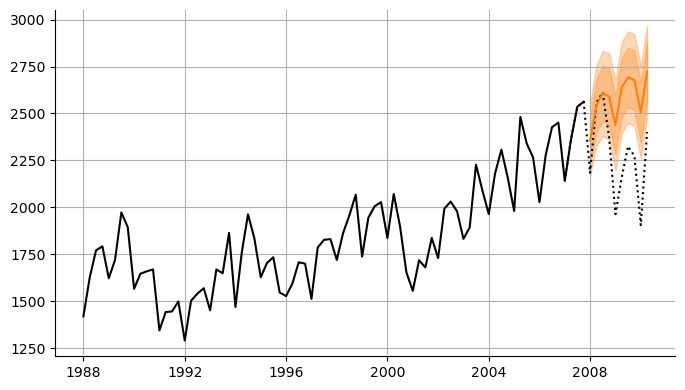

In [63]:
fig, ax = plt.subplots()
ax.plot(dtrain.Cement, 'k')
ax.plot(dtest.Cement, 'k:')

fc = afit.get_forecast(10)
ax.plot(fc.predicted_mean, color='C1')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C1', alpha=.3)

ax.grid()